### Here we tried a transfer learning using ResNet.

---



In [1]:
#!pip install plot_keras_history

In [2]:
# importing libraries

import keras
import keras.utils
import sklearn
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, MaxPool2D, Flatten, Input
from keras.layers.convolutional import Conv2D
from tensorflow.keras.layers import (
    BatchNormalization, MaxPooling2D)
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.optimizers import SGD
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os



import random
from scipy import misc
from plot_keras_history import plot_history
from keras import Model
from keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import ResNet152V2
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import ZeroPadding2D
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D,Dropout, Flatten, BatchNormalization, Concatenate, AveragePooling2D
from keras.callbacks import EarlyStopping, LearningRateScheduler

### Preparing Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DATASET_PATH = '/content/drive/MyDrive/15-Scene/'

one_hot_lookup = np.eye(15) # 15 classes

dataset_x = []
dataset_y = []

for category in sorted(os.listdir(DATASET_PATH)):
    print('loading category: '+str(int(category)))
    for fname in os.listdir(DATASET_PATH+category):
        img = cv2.imread(DATASET_PATH+category+'/'+fname, 2)
        img = cv2.resize(img, (224,224))
        dataset_x.append(np.reshape(img, [224,224,1]))
        dataset_y.append(np.reshape(one_hot_lookup[int(category)], [15]))

dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)
###shuffle dataset
p = np.random.permutation(len(dataset_x))
dataset_x = dataset_x[p]
dataset_y = dataset_y[p]
        
X_test = dataset_x[:int(len(dataset_x)/10)]
Y_test = dataset_y[:int(len(dataset_x)/10)]
X_train = dataset_x[int(len(dataset_x)/10):]
Y_train = dataset_y[int(len(dataset_x)/10):]

loading category: 0
loading category: 1
loading category: 2
loading category: 3
loading category: 4
loading category: 5
loading category: 6
loading category: 7
loading category: 8
loading category: 9
loading category: 10
loading category: 11
loading category: 12
loading category: 13
loading category: 14


### Transfer learning 

In [5]:
def transfer_model(weights, input_shape, num_output):
    transfer_model = ResNet152V2(weights=weights, include_top=False, input_shape=input_shape,pooling='max',classifier_activation='softmax')
    inp = transfer_model.input
    new_classification_layer = Dense(num_output, activation='softmax') # make a new softmax layer with 257 neurons
    out = new_classification_layer(transfer_model.layers[-1].output) # connect our new layer to the second to last layer in ResNet152V2, and make a reference to it
    final_model = keras.Model(inp, out) # create a new network between inp and out
    
    return final_model
# We create our model of transfert learning here
transfer_model = transfer_model(weights='imagenet',input_shape=(224,224,3), num_output=15)
transfer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [6]:
def compile_model(model):
    lr = 0.001
    # Optimizer for the model
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    return model
model = compile_model(transfer_model)

In [7]:
# Here to use the Resnet, we have two choices: change the input of the model of duplicate the images. We reshaped the images 
# such that the last channel is of dimension 3
X_train_repeated = np.repeat(X_train, 3, 3)
X_test_repeated = np.repeat(X_test, 3, 3)

assert X_train_repeated.shape[1:]==X_test_repeated.shape[1:]
X_train_repeated.shape

(4037, 224, 224, 3)

Epoch 1/20
127/127 [==============================] - 229s 2s/step - loss: 2.1193 - accuracy: 0.4858 - val_loss: 9.4722 - val_accuracy: 0.1406
Epoch 2/20
127/127 [==============================] - 203s 2s/step - loss: 0.9436 - accuracy: 0.7139 - val_loss: 2.6593 - val_accuracy: 0.3415
Epoch 3/20
127/127 [==============================] - 199s 2s/step - loss: 0.7028 - accuracy: 0.7785 - val_loss: 2.9414 - val_accuracy: 0.6049
Epoch 4/20
127/127 [==============================] - 203s 2s/step - loss: 0.6383 - accuracy: 0.8058 - val_loss: 1.1611 - val_accuracy: 0.6607
Epoch 5/20
127/127 [==============================] - 199s 2s/step - loss: 0.4152 - accuracy: 0.8675 - val_loss: 1.5027 - val_accuracy: 0.5960
Epoch 6/20
127/127 [==============================] - 199s 2s/step - loss: 0.3587 - accuracy: 0.8811 - val_loss: 1.6342 - val_accuracy: 0.6116
Epoch 7/20
127/127 [==============================] - 203s 2s/step - loss: 0.2801 - accuracy: 0.9180 - val_loss: 1.0880 - val_accuracy: 0.7143

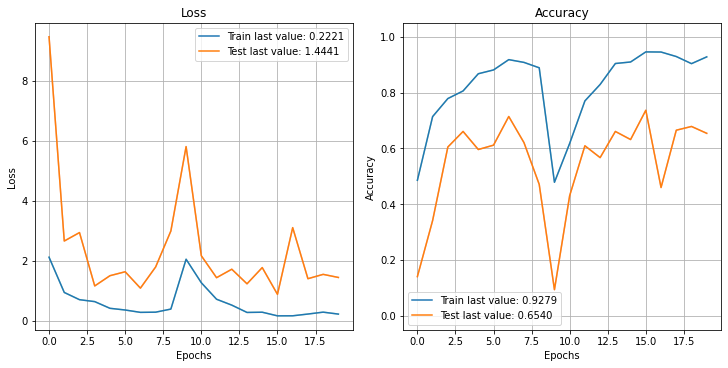

In [8]:
epochs = 20

model_history = model.fit(X_train_repeated, Y_train, validation_data=(X_test_repeated, Y_test), epochs=epochs)
loss, acc = model.evaluate(X_test_repeated, Y_test, verbose=1)

plot_history(model_history.history)
plt.show()